In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# Definition of base case:

I define a central generator that outputs $300\, \text{MW} \pm 30\%$ , with a measurement quantization of 0.5%, as allowed by the Danish TSO (Energinet). 

Note that for MVar, the allowed uncertainty is 1%

In [2]:
# Some initial parameter initialization
time = 24  # hrs
t_sample = 5 # minutes
ts = np.arange(int(time * 60/t_sample))  # time series

In [74]:
central_unit = 300000  # kW, base output
acceptable_error = 0.005 # percentage

# I define a helping function for finding the RMSE of the base pattern and quantized measurement
def rmse(base, quantized):
    return np.sqrt(((base - quantized) ** 2).mean())

# I also define the quantization function of the measurement
def quantizer(base_array,percentage):
    quant = np.round((base_array-(base_array*percentage)/2)/(base_array*percentage))*(base_array*acceptable_error)
    return quant

The RMSE of the generator is 717.0405022199465


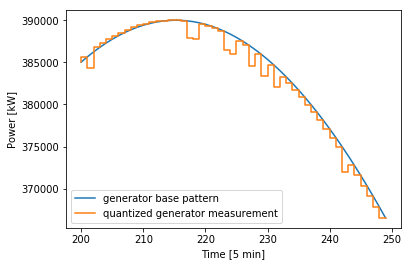

In [75]:
gen_quant=central_unit*acceptable_error  #quantization factor
#noise = np.random.random(len(ts))*0.1  # Some extra noise on the generator output, not on the measurement
noise = 0
generator_pattern = (np.sin(np.linspace(-np.pi,np.pi,len(ts)))+noise)*0.3*central_unit+central_unit # a simple sine wave
#generator_quant = np.floor((generator_pattern-gen_quant/2)/gen_quant)*gen_quant
generator_quant = quantizer(generator_pattern,acceptable_error)
gen_rmse = rmse(generator_pattern,generator_quant)
print('The RMSE of the generator is {}'.format(gen_rmse))

plt.figure()
plt.plot(ts[200:250],generator_pattern[200:250],label='generator base pattern')
plt.step(ts[200:250],generator_quant[200:250],label='quantized generator measurement',)
plt.ylabel('Power [kW]')
plt.xlabel('Time [{} min]'.format(t_sample))
plt.legend()

# Defining the individual DER base patterns

We are assuming a generic DER which can follow the same pattern as the generator, but in a much smaller scale. This could be an EV charging post.

In [46]:
# First we define a function that will generate the base pattern with a slightly different noise patterns
def pattern_making(t_sample, n, mean_val, quant_percentage, seed):
    '''# Defining EVs. It's commented out since these charging patterns don't allow us to compare to the generator
    morning_charge_time = 9  # am, hour in the morning
    morning_charge_duration = 1 # hrs
    afternoon_charge_time = 17 # hour in the afternoon
    afternoon_charge_duration = 3 # hrs
    max_charge = max_val  # kW
    error_morning = np.sin(np.linspace(0,np.pi,int(morning_charge_duration*60/t_sample)))*max_charge + np.random.random(int(morning_charge_duration*60/t_sample))*0.3
    error_afternoon = np.sin(np.linspace(0,np.pi,int(afternoon_charge_duration*60/t_sample)))*max_charge + np.random.random(int(afternoon_charge_duration*60/t_sample))*0.3
    '''
    # Defining pattern
    np.random.seed(seed)  # Change the random seed 
    noise_ev = np.random.random(n)*0.1
    base_pattern = (np.sin(np.linspace(-np.pi,np.pi,n))+noise_ev)*0.3*mean_val+mean_val
    quantizer2 = lambda x: np.round((x-(x*quant_percentage)/2)/(x*quant_percentage))*(x*quant_percentage)
    vquantizer2 = np.vectorize(quantizer2)
    #base_pattern = np.zeros(len(ts))
    #base_pattern[int(morning_charge_time*60/t_sample):int(morning_charge_time*60/t_sample+morning_charge_duration*60/t_sample)] = error_morning
    #base_pattern[int(afternoon_charge_time*60/t_sample):int(afternoon_charge_time*60/t_sample+afternoon_charge_duration*60/t_sample)] = error_afternoon
    quant_pattern = vquantizer2(base_pattern)
    return base_pattern, quant_pattern



## We can now start comparing an aggregation of a pool vs. a big generator

We assume that the DERs deliver the same output as the generator. In this case the quantization error is the same, i.e. we have to have a precision of 0.5%

In [47]:
EVs_count = 10
pattern_mat = np.zeros((len(ts),EVs_count))
quant_mat = np.zeros((len(ts),EVs_count))
for i in range(EVs_count):
    base, quant = pattern_making(t_sample,len(ts),30000,0.005,i)
    pattern_mat[:,i] = base
    quant_mat[:,i] = quant
total_pool_quant = np.sum(quant_mat, axis=1)
total_pool_base = np.sum(pattern_mat,axis=1)

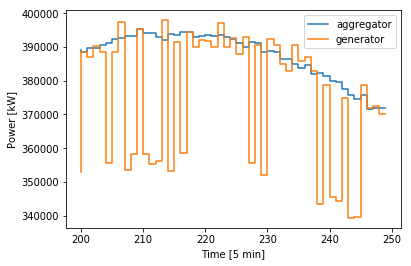

In [48]:
plt.figure()
plt.step(ts[200:250],total_pool_quant[200:250],label='aggregator')
plt.step(ts[200:250],generator_quant[200:250],label='generator')
#plt.plot(ts[200:250],generator_pattern[200:250],label='generator_base')
#plt.plot(ts[200:250],total_pool_base[200:250],label='aggregator_base')
plt.ylabel('Power [kW]')
plt.xlabel('Time [{} min]'.format(t_sample))
plt.legend()

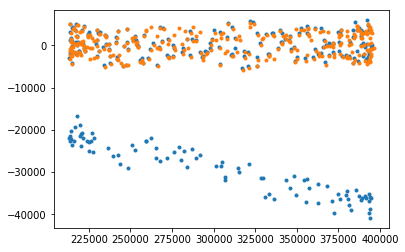

In [49]:
plt.figure()
plt.plot(total_pool_quant,generator_quant-total_pool_quant,'.')
plt.plot(total_pool_base,generator_pattern-total_pool_base,'.')

In [50]:
max_error_gen = max(abs(generator_pattern-generator_quant))
max_error_agg = max(abs(total_pool_quant-total_pool_base))
rms_error_gen = rmse(generator_pattern,generator_quant)
rms_error_agg = rmse(total_pool_quant,total_pool_base)

###
print('For an aggregation of {} units:'.format(EVs_count))
print('Maximum error in generator measurement: {} kW'.format(max_error_gen))
print('Root mean square error in generator measurement: {} kW'.format(rms_error_gen))
print('########')
print('Maximum error in aggregator measurement: {} kW'.format(max_error_agg))
print('Root mean square error in aggregator measurement: {} kW'.format(rms_error_agg))

For an aggregation of 10 units:
Maximum error in generator measurement: 39831.72259867331 kW
Root mean square error in generator measurement: 17355.824495769688 kW
########
Maximum error in aggregator measurement: 1169.63865305105 kW
Root mean square error in aggregator measurement: 440.534753805938 kW


In [51]:
EVs_count_2 = 100
pattern_mat_2 = np.zeros((len(ts),EVs_count_2))
quant_mat_2 = np.zeros((len(ts),EVs_count_2))
for i in range(EVs_count_2):
    base, quant = pattern_making(t_sample,len(ts),3000,0.005,i)
    pattern_mat_2[:,i] = base
    quant_mat_2[:,i] = quant
    
total_pool_quant_2 = np.sum(quant_mat_2, axis=1)
total_pool_base_2 = np.sum(pattern_mat_2, axis=1)

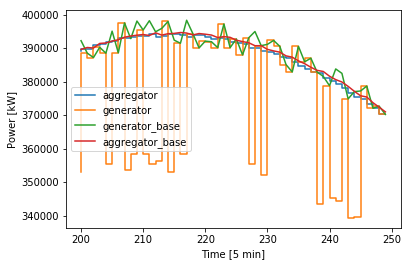

In [52]:
plt.figure()
plt.step(ts[200:250],total_pool_quant_2[200:250],label='aggregator')
plt.step(ts[200:250],generator_quant[200:250],label='generator')
plt.plot(ts[200:250],generator_pattern[200:250],label='generator_base')
plt.plot(ts[200:250],total_pool_base_2[200:250],label='aggregator_base')
plt.ylabel('Power [kW]')
plt.xlabel('Time [{} min]'.format(t_sample))
plt.legend()

In [53]:
max_error_gen = max(generator_pattern-generator_quant)
max_error_agg = max(total_pool_quant_2-total_pool_base_2)
rms_error_gen = rmse(generator_pattern,generator_quant)
rms_error_agg = rmse(total_pool_quant_2,total_pool_base_2)

###
print('Maximum error in generator measurement: {} kW'.format(max_error_gen))
print('Root mean square error in generator measurement: {} kW'.format(rms_error_gen))
print('########')
print('Maximum error in aggregator measurement: {} kW'.format(max_error_agg))
print('Root mean square error in aggregator measurement: {} kW'.format(rms_error_agg))

Maximum error in generator measurement: 39831.72259867331 kW
Root mean square error in generator measurement: 17355.824495769688 kW
########
Maximum error in aggregator measurement: -171.01298433815828 kW
Root mean square error in aggregator measurement: 379.5201130752446 kW


# Calculation of Aggregator RMSE in terms of pool size

In [54]:
max_pool = 50
step = 1

pool_base = np.zeros((len(ts),max_pool))
pool_quant = np.zeros((len(ts),max_pool))
rmse_vec = np.zeros(int(max_pool/step)-1)
n = 0
for j in range(1, max_pool,step):
    pattern_mat_3 = np.zeros((len(ts),j))
    quant_mat_3 = np.zeros((len(ts),j))
    base_pow = central_unit/(j)
    for i in range(j):
        base, quant = pattern_making(t_sample,len(ts),base_pow,0.005,i)
        pattern_mat_3[:,i] = base
        quant_mat_3[:,i] = quant

    total_pool_quant_3 = np.sum(quant_mat_3, axis=1)
    total_pool_base_3 = np.sum(pattern_mat_3, axis=1)
    pool_base[:,j-1] = total_pool_quant_3
    pool_quant[:,j-1] = total_pool_base_3
    error = rmse(total_pool_base_3,total_pool_quant_3)
    #print(error)
    rmse_vec[n]=error
    n=n+1


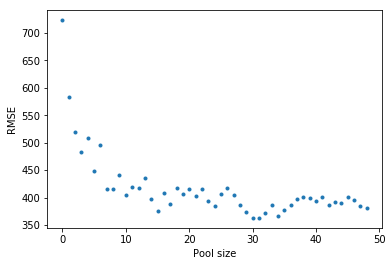

In [55]:
plt.figure()
plt.plot(rmse_vec,'.')
plt.ylabel('RMSE')
plt.xlabel('Pool size')

## Now varying over measurement quantization

We do the same analysis as before, but also varying over the quantization percentage, in order to get a 3-D figure

In [32]:
max_pool = 50
step = 1
quant_steps = 0.0005
quant_list = np.arange(0.005,0.01,quant_steps)
pool_list = np.arange(1,max_pool,step)

#pool_base_2 = np.zeros((len(ts),max_pool,len(quant_list)))
#pool_quant_2 = np.zeros((len(ts),max_pool,len(quant_list)))
rmse_mat = np.zeros((int(max_pool/step)-1,len(quant_list)))
n = 0
for size in pool_list:
    l = 0
    for quant_value in quant_list:
        pattern_mat_4 = np.zeros((len(ts),size))
        quant_mat_4 = np.zeros((len(ts),size))
        base_pow = central_unit/(size)
        for i in range(size):
            base, quant = pattern_making(t_sample,len(ts),base_pow,quant_value,i)
            pattern_mat_4[:,i] = base
            quant_mat_4[:,i] = quant

        total_pool_quant_4 = np.sum(quant_mat_4, axis=1)
        total_pool_base_4 = np.sum(pattern_mat_4, axis=1)
        #pool_base_2[:,j-1,l] = total_pool_quant_4
        #pool_quant_2[:,j-1,l] = total_pool_base_4
        error = max(np.abs(total_pool_base_4-total_pool_quant_4)/total_pool_base_4)
        #error = rmse(total_pool_base_4,total_pool_quant_4)
        rmse_mat[n,l]=error
        l=l+1
    n=n+1

In [33]:
df = pd.DataFrame(rmse_mat)
df.index = pool_list
df.columns = quant_list
df.head(20)
#np.shape(rmse_mat)
#fig3d = plt.figure()
#ax = fig3d.add_subplot(111, projection='3d')
#ax.plot3D(rmse_mat)

,0.005,0.0055,0.006,0.0065,0.007,0.0075,0.008,0.0085,0.009,0.0095
1,0.005000,0.0045,0.004,0.0055,0.006,0.0025,5.797971e-16,0.0055,0.001,0.0025
2,0.005000,0.0045,0.004,0.0055,0.006,0.0025,6.429590e-16,0.0055,0.001,0.0025
3,0.005000,0.0045,0.004,0.0055,0.006,0.0025,6.745341e-16,0.0055,0.001,0.0025
4,0.005000,0.0045,0.004,0.0055,0.006,0.0025,7.022028e-16,0.0055,0.001,0.0025
5,0.004006,0.0045,0.004,0.0055,0.006,0.0025,6.773780e-16,0.0055,0.001,0.0025
6,0.004165,0.0045,0.004,0.0055,0.006,0.0025,6.777807e-16,0.0055,0.001,0.0025
7,0.003573,0.0045,0.004,0.0055,0.006,0.0025,7.848347e-16,0.0055,0.001,0.0025
8,0.003749,0.0045,0.004,0.0055,0.006,0.0025,6.714832e-16,0.0055,0.001,0.0025
9,0.002787,0.0045,0.004,0.0055,0.006,0.0025,8.071977e-16,0.0055,0.001,0.0025
10,0.003018,0.0045,0.004,0.0055,0.006,0.0025,8.047547e-16,0.0055,0.001,0.0025


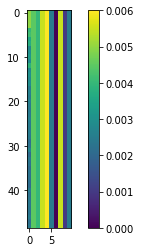

In [34]:
plt.figure()
plt.imshow(rmse_mat)
plt.colorbar()

In [108]:
220000*0.005

1100.0